This example was adapted from skaae's Lasagne [recipe](https://github.com/skaae/Recipes/blob/spatial_transform/examples/spatial_transformer_network.ipynb).  
You can download skaae's Cluttered MNIST dataset [here](https://s3.amazonaws.com/lasagne/recipes/datasets/mnist_cluttered_60x60_6distortions.npz).
This ipython notebook was adapted from Seya's spatial transformer network example
(https://github.com/EderSantana/seya/blob/keras1/examples/Spatial%20Transformer%20Networks.ipynb)

Reference at [arXiv](http://arxiv.org/abs/1506.02025)

In [18]:
%matplotlib inline

import numpy as np
np.random.seed(1337)  # for reproducibility
import matplotlib.pyplot as plt
from scipy.misc import imresize
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.utils import np_utils, generic_utils
from keras.optimizers import Adam, SGD

import keras.backend as K


batch_size = 128
nb_classes = 10
nb_epoch = 12

DIM = 60
mnist_cluttered = "../datasets/mnist_cluttered_60x60_6distortions.npz"

In [19]:
from spatial_transformer_filter import SpatialTransformerFilter

In [20]:
data = np.load(mnist_cluttered)
X_train, y_train = data['x_train'], np.argmax(data['y_train'], axis=-1)
print("X_train sample:", X_train[0])
X_valid, y_valid = data['x_valid'], np.argmax(data['y_valid'], axis=-1)
X_test, y_test = data['x_test'], np.argmax(data['y_test'], axis=-1)
# reshape for convolutions
X_train = X_train.reshape((X_train.shape[0], DIM, DIM, 1))
X_valid = X_valid.reshape((X_valid.shape[0], DIM, DIM, 1))
X_test = X_test.reshape((X_test.shape[0], DIM, DIM, 1))
#one hot
y_train = np_utils.to_categorical(y_train, nb_classes)
y_valid = np_utils.to_categorical(y_valid, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

print("Train samples: {}".format(X_train.shape))
print("Validation samples: {}".format(X_valid.shape))
print("Test samples: {}".format(X_test.shape))
print("sample output:",y_train)
print("output shape:", y_train.shape)
input_shape =  np.squeeze(X_train.shape[1:])
input_shape = (60,60,1)
print("Input shape:",input_shape)

('X_train sample:', array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))
Train samples: (50000, 60, 60, 1)
Validation samples: (10000, 60, 60, 1)
Test samples: (10000, 60, 60, 1)
('sample output:', array([[0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.]]))
('output shape:', (50000, 10))
('Input shape:', (60, 60, 1))


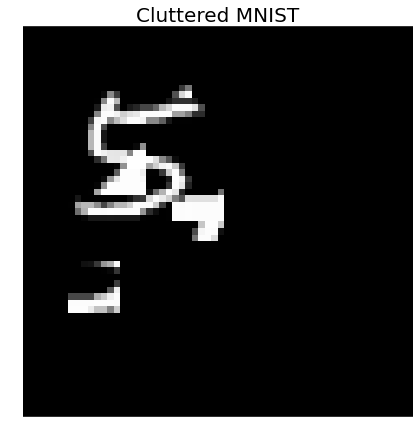

In [21]:
plt.figure(figsize=(7,7))
plt.imshow(X_train[101].reshape(DIM, DIM), cmap='gray', interpolation='none')
plt.title('Cluttered MNIST', fontsize=20)
plt.axis('off')
plt.show()

In [22]:
# locnet = Sequential()
# locnet.add(MaxPooling2D(pool_size=(2,2), input_shape=input_shape))
# locnet.add(Convolution2D(20, (5, 5)))
# locnet.add(MaxPooling2D(pool_size=(2,2)))
# locnet.add(Convolution2D(20, (5, 5)))

# locnet.add(Flatten())
# locnet.add(Dense(50))
# locnet.add(Activation('relu'))
# locnet.add(Dense(6, weights=weights))
# #locnet.add(Activation('sigmoid'))

In [23]:
# initial weights for the localisation network or the finding the transformation matrix
b = np.zeros((2, 3), dtype='float32')
b[0, 0] = 1
b[1, 1] = 1
W = np.zeros((50, 6), dtype='float32')
weights = [W, b.flatten()]

In [24]:
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model
from keras import layers 
# We need two inputs for the localization network  for the filters
main_input = Input(shape=(3,3,400), name='image')
auxiliary_input = Input(shape=(3, 3, 1), name='filter')
merged_input = layers.concatenate([main_input, auxiliary_input], axis = 3)

## Localization network for filter 1

In [25]:
modified_input_shape = (3,3,401)

locnet = Sequential()
# locnet.add(MaxPooling2D(pool_size=(2,2), input_shape=modified_input_shape))
locnet.add(Convolution2D(20, (2, 2) , input_shape=modified_input_shape))
locnet.add(MaxPooling2D(pool_size=(2,2)))
# locnet.add(Convolution2D(20, (5, 5)))

locnet.add(Flatten())
locnet.add(Dense(50))
locnet.add(Activation('relu'))
locnet.add(Dense(6, weights=weights))
#locnet.add(Activation('sigmoid'))

# Main Network

In [26]:
# model = Sequential()
# model.add(Convolution2D(1, (3,3), padding='same'))
x = Convolution2D(1, (3, 3), padding='same',  activation='relu')(main_input)
stnf = SpatialTransformerFilter(localization_net=locnet,
                             output_size=(3,3))([main_input, auxiliary_input], axis = 3)

# How to set the weights of the layer after every step (set filter in the conv layer)
x = Convolution2D(1, (3, 3), padding='same', trainable=False,  activation='relu')(main_input)
x = Convolution2D(32, (3, 3), padding='same',  activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Convolution2D(32, (3, 3), padding='same',  activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(nb_classes, activation = 'softmax')(x)
model = Model(input=[merged_input], output = nb_classes)
model.compile(loss='categorical_crossentropy', optimizer='adam')

NameError: global name 'SpatialTransformer' is not defined

In [13]:
model.summary()

NameError: name 'model' is not defined

In [50]:
XX = model.input
YY = model.layers[0].output
# to get th output of an intermediate layer i.e. after spatial transformation layer, given the input
F = K.function([XX], [YY])

In [51]:
print(X_train.shape[0]/batch_size)

390


In [52]:
nb_epochs = 10 # you probably want to go longer than this
batch_size = 256
fig = plt.figure()
try:
    for e in range(nb_epochs):
        print('-'*40)
        #progbar = generic_utils.Progbar(X_train.shape[0])
        for b in range(150):
            #print(b)
            f = b * batch_size
            l = (b+1) * batch_size
            X_batch = X_train[f:l].astype('float32')
            y_batch = y_train[f:l].astype('float32')
            loss = model.train_on_batch(X_batch, y_batch)
            #print(loss)
            #progbar.add(X_batch.shape[0], values=[("train loss", loss)])
        scorev = model.evaluate(X_valid, y_valid, verbose=1)
        scoret = model.evaluate(X_test, y_test, verbose=1)
        print('Epoch: {0} | Valid: {1} | Test: {2}'.format(e, scorev, scoret))
        
        if e % 1 == 0:
            # The output of the intermediate spatial transformation layer
            Xresult = F([X_batch[:9]])
            plt.clf()
            for i in range(9):
                plt.subplot(3, 3, i+1)
                image = np.squeeze(Xresult[0][i])
                plt.imshow(image, cmap='gray')
                plt.axis('off')
            fig.canvas.draw()
            plt.show()
        
except KeyboardInterrupt:
    pass

----------------------------------------


ValueError: Error when checking input: expected spatial_transformer_2_input to have shape (3, 3, 401) but got array with shape (60, 60, 1)

### Visualizing what the Spatial Transformer learned

In [14]:
Xaug = X_train[:9]
Xresult = F([Xaug.astype('float32')])

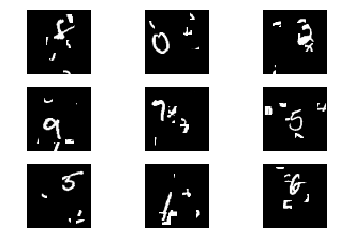

In [15]:
# input
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.squeeze(Xaug[i]), cmap='gray')
    plt.axis('off')

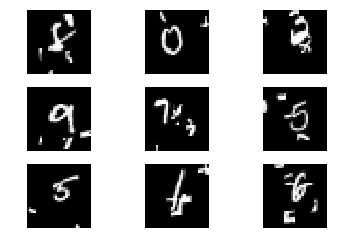

In [16]:
# output
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.squeeze(Xresult[0][i]), cmap='gray')
    plt.axis('off')